In [8]:
# Reference:
# /exp/rhuang/icefall_align2/egs/librispeech/ASR/ruizhe_hmm/run.ipynb
# /exp/rhuang/icefall_align2/icefall/bpe_graph_compiler.py

In [1]:
import sys
sys.path.append("/scratch4/skhudan1/rhuang25/k2/k2/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/k2/build_debug/lib/")
sys.path.append("/scratch4/skhudan1/rhuang25/icefall/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/kaldifeat/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/build/lib/")

In [3]:
import k2
import sentencepiece as spm

In [4]:
sp = spm.SentencePieceProcessor()
sp.load("/home/rhuang25/work/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [12]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[24, 102, 70, 393, 12, 17, 19, 80],
 [154, 37, 345, 21, 3, 225, 102, 52, 3],
 [49, 11, 7, 161, 24]]

In [13]:
word_ids_list = [[24, 102, 70, 393, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70, 393, 12, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70]]
word_ids_list = [[49, 11, 7, 161, 24]]

In [14]:
graphs = k2.ctc_graph(word_ids_list, modified=False, device='cpu')

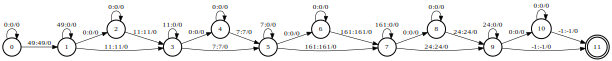

In [15]:
k2.to_dot(graphs[0])

In [16]:
graph = graphs[0]
c_str = k2.to_str_simple(graph)

In [17]:
arcs = c_str.strip().split("\n")
arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
final_state = int(arcs[-1])
arcs = arcs[:-1]
arcs = [tuple(map(int, a.split())) for a in arcs]

In [18]:
arcs

[(0, 0, 0, 0, 0),
 (0, 1, 49, 49, 0),
 (1, 2, 0, 0, 0),
 (1, 1, 49, 0, 0),
 (1, 3, 11, 11, 0),
 (2, 2, 0, 0, 0),
 (2, 3, 11, 11, 0),
 (3, 4, 0, 0, 0),
 (3, 3, 11, 0, 0),
 (3, 5, 7, 7, 0),
 (4, 4, 0, 0, 0),
 (4, 5, 7, 7, 0),
 (5, 6, 0, 0, 0),
 (5, 5, 7, 0, 0),
 (5, 7, 161, 161, 0),
 (6, 6, 0, 0, 0),
 (6, 7, 161, 161, 0),
 (7, 8, 0, 0, 0),
 (7, 7, 161, 0, 0),
 (7, 9, 24, 24, 0),
 (8, 8, 0, 0, 0),
 (8, 9, 24, 24, 0),
 (9, 10, 0, 0, 0),
 (9, 9, 24, 0, 0),
 (9, 11, -1, -1, 0),
 (10, 10, 0, 0, 0),
 (10, 11, -1, -1, 0)]

In [11]:
def make_factor_transducer1(word_id_list):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [12]:
def make_factor_transducer2(word_id_list, return_str=False, blank_penalty=-1):
    # This is the factor transducer where blank symbols at the beginning and ending of the graph is penalized
    # Last resort: use a cheap alignment model to get a subgraph of the big graph first

    # blank_penalty should be negative

    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    arc0 = arcs[0]
    arcs_last = [a for a in arcs[-5:] if a[2] > 0]

    arcs = [(0, 0, 0, 0, blank_penalty)] + arcs[1:-5] + arcs_last

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    # arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]
    arcs += [(n, final_state - 1, 0, 0, blank_penalty) for n, l in non_eps_nodes]
    arcs += [(final_state - 1, final_state - 1, 0, 0, blank_penalty)]
    arcs += [(final_state - 1, final_state, -1, -1, 0)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        return fst

In [19]:
def make_factor_transducer3(word_id_list, word_start_symbols):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    non_eps_nodes2 = set((arc[0], arc[3]) for arc in arcs if arc[3] > 0 and arc[3] in word_start_symbols)   # if this node has a non-eps, word-start out-going arc
    non_eps_nodes2 = [(n, l) for n, l in non_eps_nodes2 if 0 < n < final_state - 2]
    arcs += [(n, final_state, -1, -1, 0) for n, l in non_eps_nodes2]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [26]:
# graph_ft = make_factor_transducer1(word_ids_list[0])
# graph_ft = make_factor_transducer2(word_ids_list[0])
graph_ft = make_factor_transducer3(word_ids_list[0], word_start_symbols=[i for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')])

TypeError: '<' not supported between instances of 'int' and 'tuple'

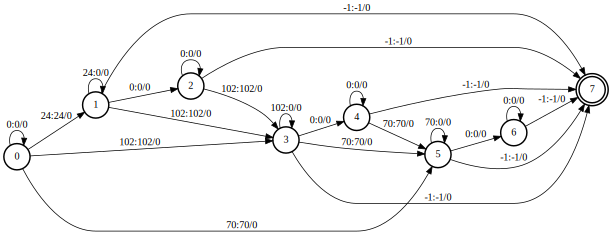

In [20]:
k2.to_dot(graph_ft)

In [24]:
[sp.id_to_piece(i) for i in range(sp.vocab_size()) if sp.id_to_piece(i).startswith('▁')]

['▁THE',
 '▁A',
 '▁AND',
 '▁OF',
 '▁TO',
 '▁IN',
 '▁S',
 '▁I',
 '▁HE',
 '▁',
 '▁THAT',
 '▁IT',
 '▁WAS',
 '▁BE',
 '▁FOR',
 '▁C',
 '▁HIS',
 '▁YOU',
 '▁RE',
 '▁E',
 '▁WITH',
 '▁B',
 '▁HER',
 '▁AS',
 '▁P',
 '▁HAD',
 '▁SO',
 '▁IS',
 '▁T',
 '▁NOT',
 '▁BUT',
 '▁F',
 '▁ON',
 '▁SHE',
 '▁DE',
 '▁ME',
 '▁AT',
 '▁ST',
 '▁G',
 '▁NO',
 '▁HIM',
 '▁W',
 '▁WE',
 '▁ALL',
 '▁DO',
 '▁HAVE',
 '▁MY',
 '▁BY',
 '▁THIS',
 '▁WHICH',
 '▁CON',
 '▁THEY',
 '▁TH',
 '▁D',
 '▁GO',
 '▁SAID',
 '▁FROM',
 '▁WHO',
 '▁ONE',
 '▁CA',
 '▁O',
 '▁LA',
 '▁WERE',
 '▁AN',
 '▁MAN',
 '▁FA',
 '▁OR',
 '▁MI',
 '▁SH',
 '▁MO',
 '▁EX',
 '▁HA',
 '▁SU',
 '▁BO',
 '▁WHEN',
 '▁FI',
 '▁MA',
 '▁PRO',
 '▁WOULD',
 '▁HO',
 '▁THERE',
 '▁WHAT',
 '▁FE',
 '▁PA',
 '▁PO',
 '▁OUT',
 '▁IF',
 '▁THEIR',
 '▁LI',
 '▁RO',
 '▁ARE',
 '▁WILL',
 '▁UP',
 '▁SEE',
 '▁WA',
 '▁UN',
 '▁SP',
 '▁LO',
 '▁YE',
 '▁LE',
 '▁BEEN',
 '▁RA',
 '▁COULD',
 '▁DIS',
 '▁THEM',
 '▁SA',
 '▁SOME',
 '▁NE',
 '▁CO',
 '▁MORE',
 '▁US',
 '▁K',
 '▁EN',
 '▁INTO',
 '▁KNOW',
 '▁YOUR',
 '▁TIME',
 '▁NO